# Drosophila MultiVariate Analysis

*Done by : Amir MAHMOUDI & Elisabeth DAO*

# Table of Contents 

**Introduction**

**1. PCA-based clustering**

*1.1 Average day and average drosophila profile*

*1.2 Visualisation*

*1.3 Dataframe creation for each regime*

*1.4 PCA Analysis*

*1.5 Genotype Clustering*

*1.6 Bin Clustering based on time of the day*

**2. Tensorial study**

*2.1 3D Tensor Study*

*2.1.1 PARAFAC / CANDECOMP decomposition*

*2.1.2 3D Tensor Clustering Study on Genotype Factor Matrix (Kmeans)*

*2.2 4D Tensor Study*

*2.2.1 PARAFAC / CANDECOMP decomposition*

*2.1.2 4D Tensor Clustering Study on Genotype Factor Matrix (Kmeans)*

**Conclusion**

# Introduction

The purpose of this project is to analyse how the drosophila's genotype influence its circadian rhythm. For that, we have different population of drosophila that have undergone gene mutations. We observe them during 5 days on different lighting setup :
- **Regime 1** : 16 hours of light 8 hours of darkness
- **Regime 2** : 12 hours of light 12 hours of darkness
- **Regime 3** : 16 hours of light 8 hours of darkness (using a red light)

The different features we have are : 
- **Bin i** : representing a period of 30 min of observation the value assigned at each bin is how many times the drosphila crossed the beam (to observe the activity), we thus have 48 bin per day so 240 in total
- **refMC** : the matricule for each drosophila
- **R** : the regime used for the experiment
- **Genotype** : the genotype of the individual

This experiment is done on the same temperature and all the drosphilas are males. 

Along this document, we process clustering methos in order to classify drosophila behaviors according to their genotypes

In [1]:
#Lib import

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorly
from sklearn.cluster import KMeans
from tensorly.decomposition import parafac
from mpl_toolkits import mplot3d
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
#Load data
df=pd.read_csv('Table_data_total.csv',sep=';',header=0)

# 1. PCA - based Clustering

The aim of this part is to visualize the activity of the drosophila over time.

To better appreciate the characteristic activity of Drosophila, we average the activities over the 5 days and between Drosophila of the same line.
This averaging step will allow us to summarize the typical activity of a Drosophila of a given genotype over one day.

After averaging, we will have a table nb_genotypes x bin_on_a_day of dimension 204x48 that we will analyze.

Then we apply a clustering method based on Kmeans to identify the homogeneous Drosophila genotypes (i.e. with similar activity profiles). 

## 1.1 Average day and average drosophila profile

First step is to visualize the activity of the drosophila over time. 
For that, we average the activities over the 5 days and between Drosophila of same genotype

In [3]:
for i in range(1,49):#since we repeat the same experiment on 5 days we will avg the results to obtain an avg day type
    str_='avg_bin_'+str(i)
    str_list=[]
    for j in range(5):
        str_list.append('Bin '+str(i+j*48))
    df[str_]=df[str_list].mean(axis=1)

avg_df=df.drop(df.columns[:240],axis=1)

In [4]:
df_genotype = avg_df.drop(['date','refMC'],axis=1)
df_genotype = df_genotype.groupby(['genotype','R']).mean()
df_genotype.head(5)

avg_bin_1  avg_bin_2  avg_bin_3  avg_bin_4  avg_bin_5  \
genotype            R                                                          
;;cry^02            1  11.480625   4.486875   2.390000   1.803750   1.390000   
                    2   3.162500   2.279375   1.840625   1.730000   1.447500   
                    3   1.843125   1.011875   0.792500   0.690000   0.422500   
;;ort^1, HisCl1^134 1  18.586667   8.475556   4.520635   3.544762   2.851429   
                    2   9.405079   5.965714   4.426667   4.144127   3.836190   

                       avg_bin_6  avg_bin_7  avg_bin_8  avg_bin_9  avg_bin_10  \
genotype            R                                                           
;;cry^02            1   1.426875   1.719375   1.556875   2.118750    2.329375   
                    2   1.295000   1.783750   1.560000   1.931875    1.915000   
                    3   0.607500   0.430000   0.561250   0.661875    0.868750   
;;ort^1, HisCl1^134 1   3.401905   3.522540   3.419683   4.084444    4.606349   
                    2   4.102222   4.081905   5.151111   5.010159    5.429206   

                       ...  avg_bin_39  avg_bin_40  avg_bin_41  avg_bin_42  \
genotype            R  ...                                                   
;;cry^02            1  ...   16.915625   18.660625   21.076250   23.388125   
                    2  ...   14.926250   17.169375   18.591250   20.349375   
                    3  ...   18.231875   19.810000   21.394375   22.965000   
;;ort^1, HisCl1^134 1  ...   21.073016   25.406984   30.648889   34.556825   
                    2  ...   19.313016   21.776508   25.192381   27.887619   

                       avg_bin_43  avg_bin_44  avg_bin_45  avg_bin_46  \
genotype            R                                                   
;;cry^02            1   26.078750   29.015625   31.191250   32.556875   
                    2   22.558125   44.756875   17.173125    9.003125   
                    3   23.669375   24.790000   25.664375   26.298750   
;;ort^1, HisCl1^134 1   36.167619   35.237460   31.133968   25.890159   
                    2   32.138413   38.913651   34.935238   28.227302   

                       avg_bin_47  avg_bin_48  
genotype            R                          
;;cry^02            1   33.746875   60.708750  
                    2    5.310625    3.631875  
                    3   27.506250   25.600625  
;;ort^1, HisCl1^134 1   20.340952   35.067302  
                    2   18.557460   12.162540  

[5 rows x 48 columns]

## 1.2 Visualisation

In [5]:
def color_grade_bar(regime):
    color=[]
    if regime==1 or regime==3:
        dark=8
    else:
        dark=12

    for i in range(48):
        if i<dark or i>=48-dark:
            color.append('#000000')
        else:
            if regime==3:
                color.append('#FF0000')
            else:
                color.append('#808080')
    
    return color

"""def plot_bars(genotype,regime,activity):
    day=range(48)
    color=color_grade_bar(regime)
    plt.figure(figsize=(5,2))
    plt.bar(day,activity,color=color)
    plt.xlabel('Bin')
    plt.ylabel('beam crosses/30 min')
    plt.title('Regime '+str(regime)+' for Genotype :'+genotype)
    plt.show()"""

"def plot_bars(genotype,regime,activity):\n    day=range(48)\n    color=color_grade_bar(regime)\n    plt.figure(figsize=(5,2))\n    plt.bar(day,activity,color=color)\n    plt.xlabel('Bin')\n    plt.ylabel('beam crosses/30 min')\n    plt.title('Regime '+str(regime)+' for Genotype :'+genotype)\n    plt.show()"

In [6]:
def multiplot_bars(genotype,regime,activity,nrow,ncol):
    """
    Plot multiple circadian activity bars for each genotype and regime given
    """
    _,ax=plt.subplots(nrow, ncol,figsize=(20,10))
    count=0
    day=range(48)
    for r in range(nrow):
        for c in range(ncol):
            color=color_grade_bar(regime[count])
            ax[r,c].bar(day,activity[count],color=color)
            ax[r,c].set_xlabel('Bin')
            ax[r,c].set_ylabel('beam crosses/30 min')
            ax[r,c].set_title('Regime '+str(regime[count])+' for Genotype :'+genotype[count])
            count+=1
    plt.show()

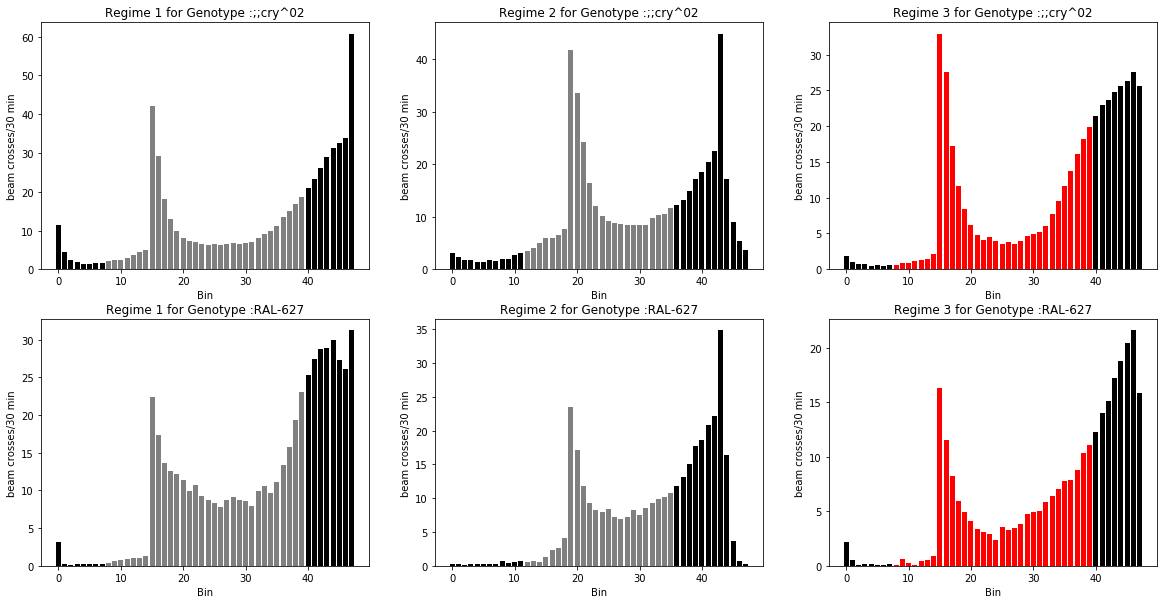

In [7]:
genotype=[]
regime=[]
activity=[]
#to_plot=[(0,1),(39,40),(392,393),(133,134)] #index of genotype and regime to plot
to_plot=[(0,1),(1,2),(2,3),(390,391),(391,392),(392,393)]
for lb,rb in to_plot:
    info,data=next(df_genotype[lb:rb].iterrows())
    genotype.append(info[0])
    regime.append(info[1])
    activity.append(data)

multiplot_bars(genotype,regime,activity,2,3)

**Observation**
Regarding the graph we obtain we see here for the genotype : ;;cry^02 they are sensible to the blue light the drosphila tends to be more active in regime 1 and 2 with a peak during light time of 41~43 which is different in regime 3 the peak is only at 33. In all of them, we observe an "inactivity" during the morning between 00AM and 4AM for R1 and R3 and until 6AM for R2. Since the dark time is longer in R2 the day peak activity is delayed from 8AM for R1 to 9AM for R2. Also the night peak is sooner in R2 with a smoother decrease of activity during the night. The increase of activity during the afternoon is very smooth and common for the 3 regimes.

We have a similar observation for the other genotype but its activity is less intense.

Let's plot the percentage of light on activity for each genotype and each regime

In [8]:
def percent_light_activity(df):
    R_1=[]
    R_2=[]
    R_3=[]
    for info,data in df.iterrows():
        if info[1]==1 or info[1]==3:
            dark=8
        else:
            dark=12

        if data.sum()>0:
            avg_light_activity=100*data[dark:48-dark].sum()/data.sum()
        else: 
            avg_light_activity=0

        if info[1]==1:
            R_1.append((info[0],avg_light_activity))
        elif info[1]==2:
            R_2.append((info[0],avg_light_activity))
        elif info[1]==3:
            R_3.append((info[0],avg_light_activity))
    
    return R_1,R_2,R_3

In [9]:
R_1,R_2,R_3=percent_light_activity(df_genotype)

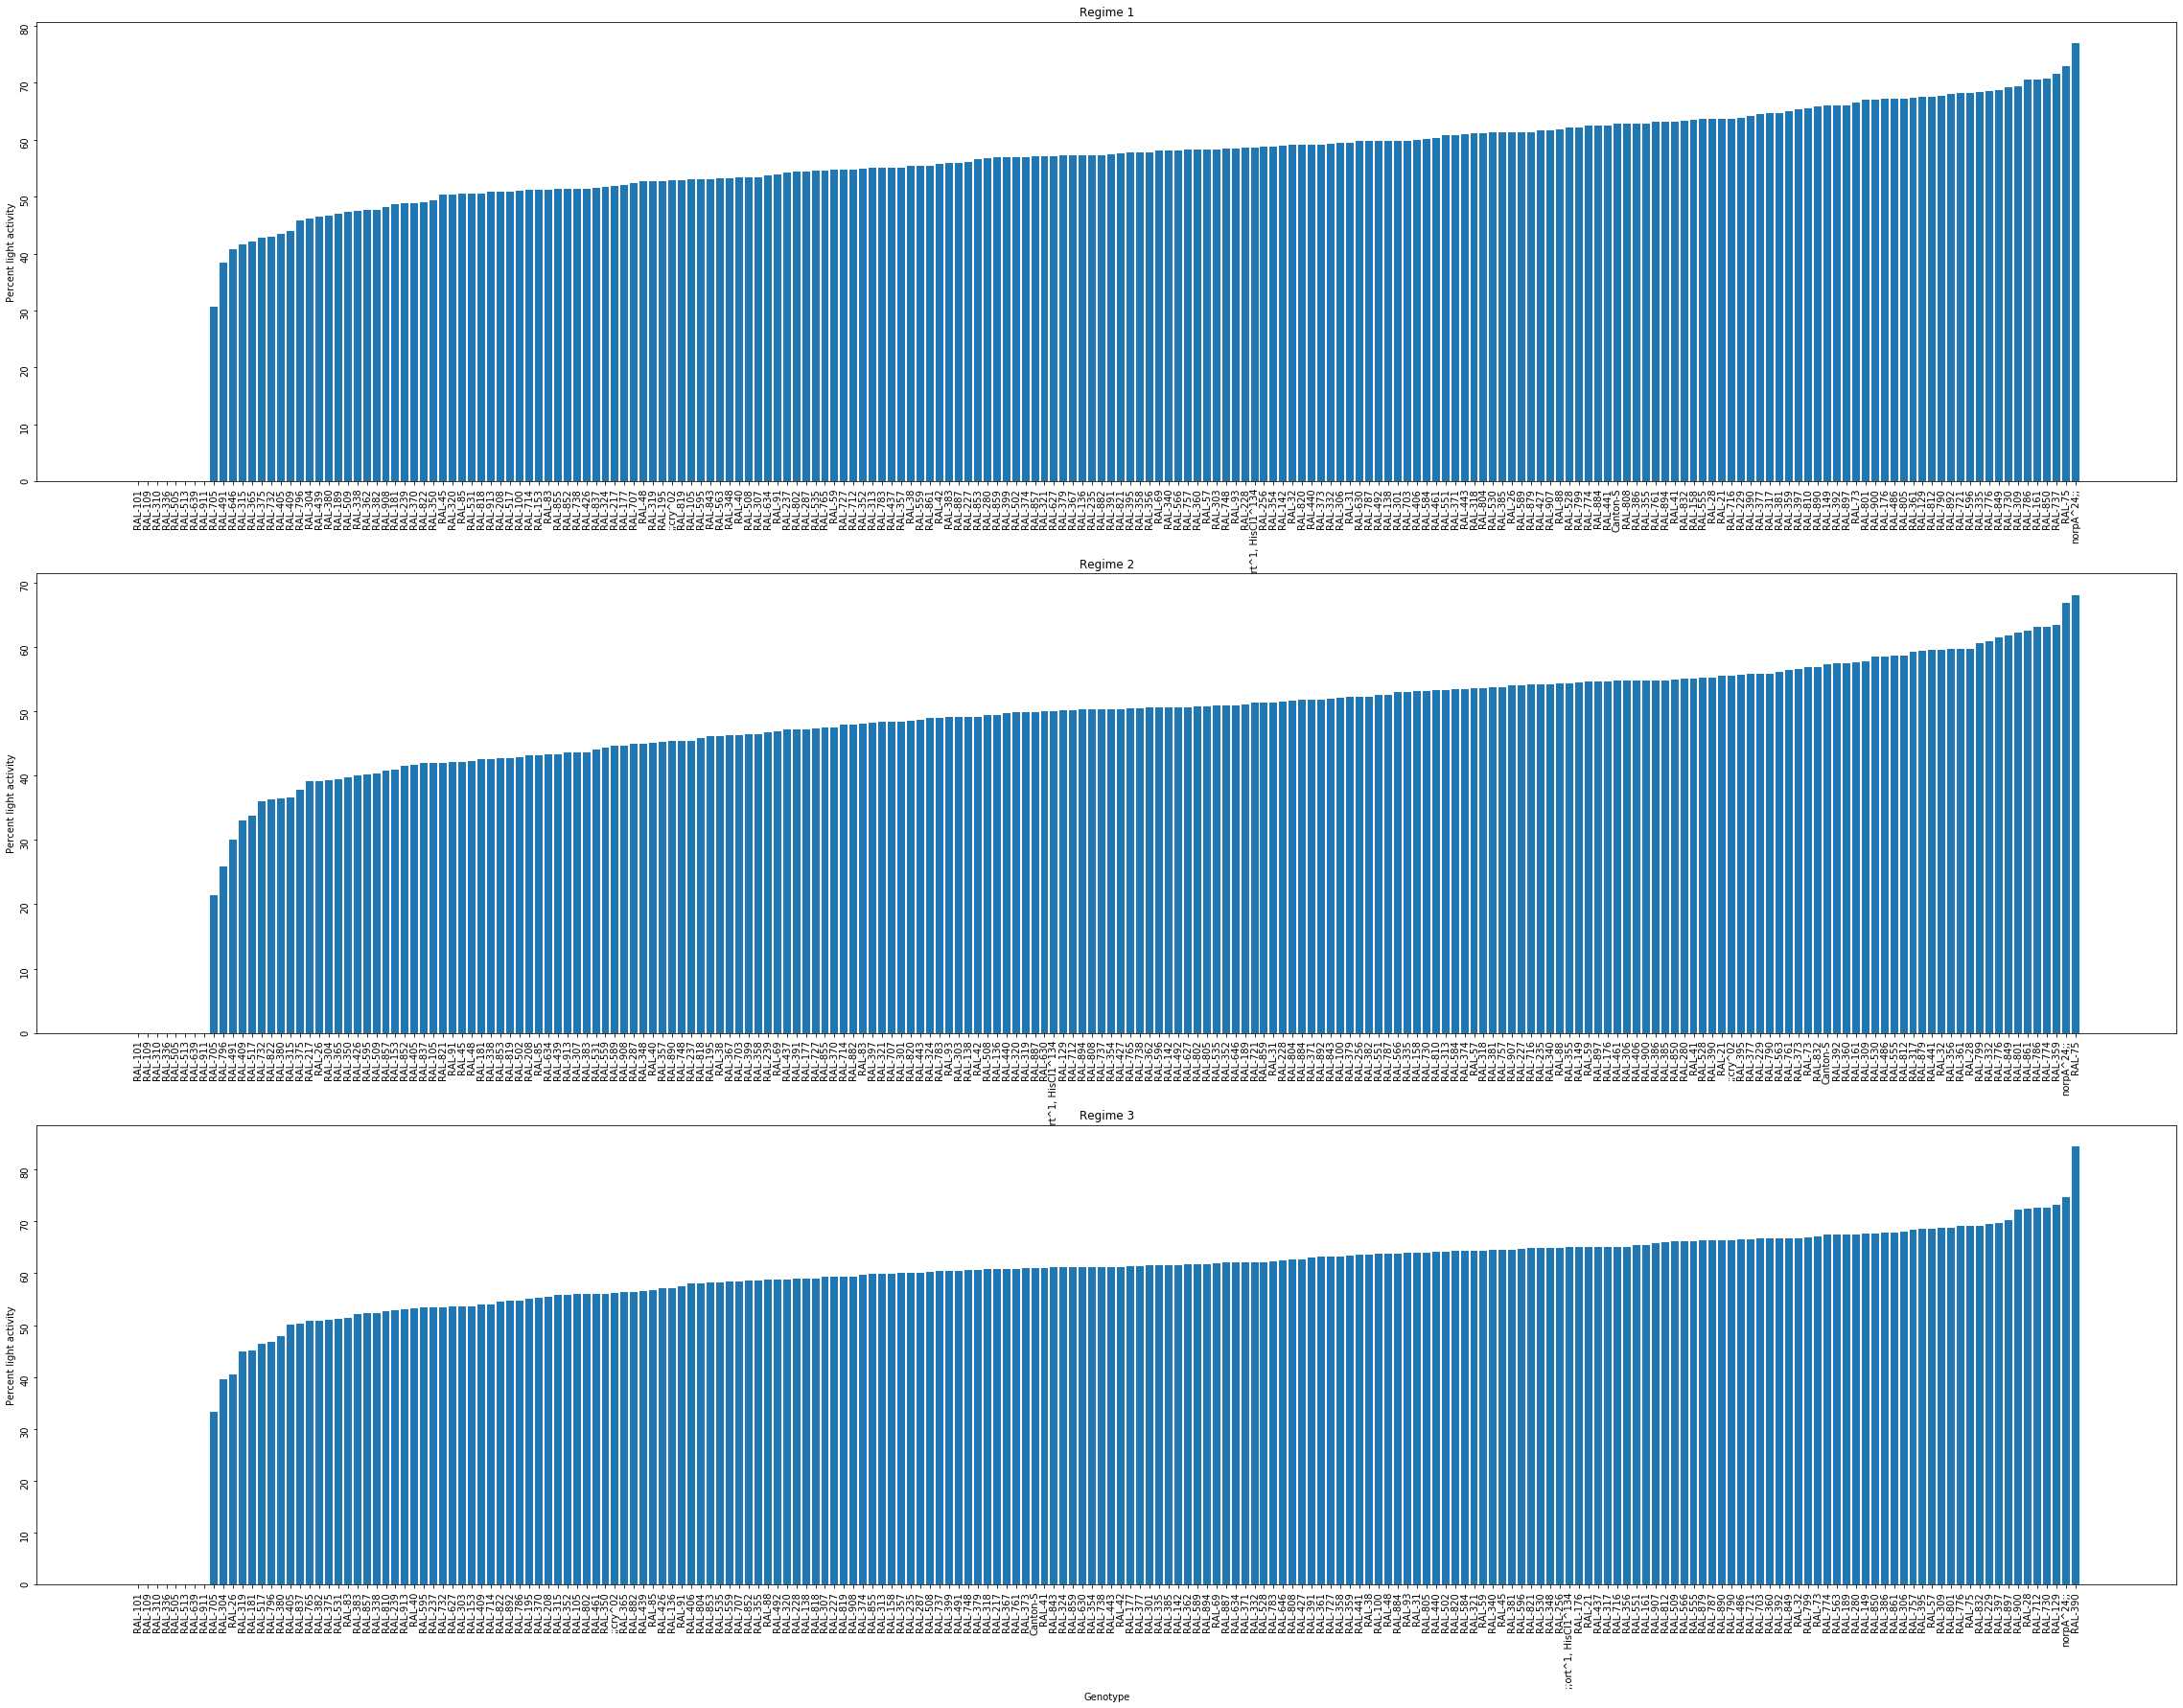

In [10]:
fig,ax=plt.subplots(3,1,figsize=(40,30))
ax[0].bar(*zip(*sorted(R_1, key=lambda tup: tup[1])))
ax[1].bar(*zip(*sorted(R_2, key=lambda tup: tup[1])))
ax[2].bar(*zip(*sorted(R_3, key=lambda tup: tup[1])))
for i in range(3):
    ax[i].tick_params(labelrotation=90)
    ax[i].set_xlabel('Genotype')
    ax[i].set_ylabel('Percent light activity')
    ax[i].set_title('Regime '+str(i+1))
plt.show()

**If you can not see clearly this graph** : open the Percent_light_activity.png to see clearly the labels and values

**Observation** : We observe here for the regime 2 we have less percent of light activity since the dark period is longer (12 hours instead of 8 for the others). Also comparing the plot for the regime 1 and 3 we have more or less a similar light activity curve but the genotype are not in the same order for instance : the ;;ort^1, HisCl1^134 genotype has a 59% of activity done during light for the regime 1 and 62% for the regime 3.

## 1.3 Dataframe creation for each regime

We isolate each regime because the standard scaler we will use need to be done separately on each regime

In [11]:
R_1=[]
R_2=[]
R_3=[]
for info,data in df_genotype.iterrows():
    data=list(data)
    data.append(info[0])
    if info[1]==1:
        R_1.append(data)
    elif info[1]==2:
        R_2.append(data)
    elif info[1]==3:
        R_3.append(data)

df_R1=pd.DataFrame(R_1,columns=list(df_genotype.columns)+['genotype'])
df_R2=pd.DataFrame(R_2,columns=df_R1.columns)
df_R3=pd.DataFrame(R_3,columns=df_R1.columns)

In [12]:
df_R1.head(5)

,avg_bin_1,avg_bin_2,avg_bin_3,avg_bin_4,avg_bin_5,avg_bin_6,avg_bin_7,avg_bin_8,avg_bin_9,avg_bin_10,...,avg_bin_40,avg_bin_41,avg_bin_42,avg_bin_43,avg_bin_44,avg_bin_45,avg_bin_46,avg_bin_47,avg_bin_48,genotype
0,11.480625,4.486875,2.390000,1.803750,1.390000,1.426875,1.719375,1.556875,2.118750,2.329375,...,18.660625,21.076250,23.388125,26.078750,29.015625,31.191250,32.556875,33.746875,60.708750,;;cry^02
1,18.586667,8.475556,4.520635,3.544762,2.851429,3.401905,3.522540,3.419683,4.084444,4.606349,...,25.406984,30.648889,34.556825,36.167619,35.237460,31.133968,25.890159,20.340952,35.067302,";;ort^1, HisCl1^134"
2,1.955625,1.443750,1.376250,1.457500,1.267500,1.549375,1.635625,2.364375,2.096875,2.503750,...,29.790625,33.841875,36.169375,38.861250,40.406250,41.191250,40.766875,39.198750,32.450625,Canton-S
3,0.287500,0.793750,0.962500,1.187500,1.056250,1.312500,0.900000,1.443750,1.475000,1.112500,...,37.331250,46.337500,55.100000,54.937500,54.287500,45.056250,35.593750,25.225000,15.293750,RAL-100
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,RAL-101


## 1.4 PCA Analysis

We will first apply a PCA on the df_genotype to observe if have clusters between the bins. PCA is done by scale so we need to scale the features in our data before applying PCA. StandardScaler will standardize the dataset’s features onto unit scale (mean = 0 and variance = 1) which is a requirement for the optimal performance of many machine learning algorithms.

In [13]:
def PCA_plot(df,n_components,R):
    """
    Plot the PCA of the dataframe given
    """
    df_scaled=StandardScaler().fit_transform(df)
    pca=PCA(n_components=n_components)
    pca.fit(df_scaled)
    df_pca=pca.transform(df_scaled)
    explained_variance_pca=pca.explained_variance_ratio_
    pca_comp=abs(pca.components_)
    if n_components==2:
        plt.scatter(df_pca[:,0],df_pca[:,1],c=df[df.columns[-1]])
        plt.title('PCA on Regime'+str(R))
        plt.xlabel('PCA 1')
        plt.ylabel('PCA 2')
        plt.show()
    
    return explained_variance_pca,pca_comp


First we will plot the explained variance ratio for each regime with a number of components of 15 since we tried for all 48 features but the last were closely equal to 0

In [14]:
exp_var_pca_R1,pca_comp_R1=PCA_plot(df_R1.loc[:,df_R1.columns!='genotype'],15,1)
exp_var_pca_R2,pca_comp_R2=PCA_plot(df_R2.loc[:,df_R2.columns!='genotype'],15,2)
exp_var_pca_R3,pca_comp_R3=PCA_plot(df_R3.loc[:,df_R3.columns!='genotype'],15,3)

Text(0.5, 0, 'Principal component index')

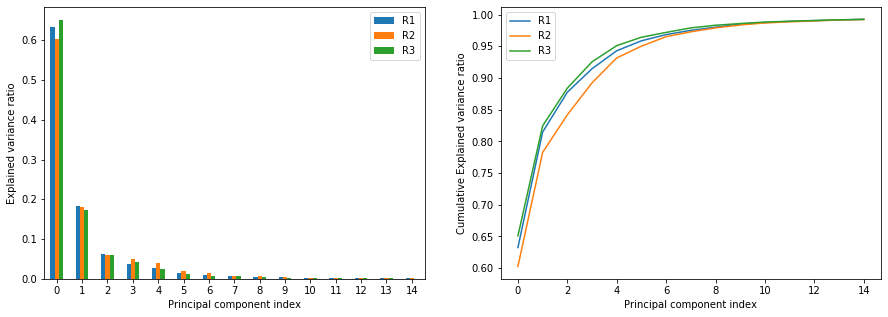

In [15]:
"""
Individual Explained Variance Ratio for each PCA & Cumulative Explained Variance Ratio
"""
df_exp_var_pca=pd.DataFrame(np.array([exp_var_pca_R1,exp_var_pca_R2,exp_var_pca_R3]).T,columns=['R1','R2','R3'])
df_cum_exp_var_pca=df_exp_var_pca.cumsum()

fig,ax=plt.subplots(1,2,figsize=(15,5))
el=df_exp_var_pca.plot(kind='bar',ax=ax[0],rot=0)
el.set_ylabel('Explained variance ratio')
el.set_xlabel('Principal component index')
el=df_cum_exp_var_pca.plot(ax=ax[1],rot=0)
el.set_ylabel('Cumulative Explained variance ratio')
el.set_xlabel('Principal component index')

**Observation**
We see in the figure above that the first 2 components explain between 83% and 78% of the explained variance ratio. Also, from the pca component index 4 and onwards the ratio is less than 0.06 and near 0 from the index 8. Comparing the cumulative ratio, the third regime is the best explained by the pca components overall the least is actually the regime 2. The first pca component is the one explaining the most with a ratio around 0.6 and 0.63 for all regimes.

For the PCA plot we will use only the 2 first components but the five first components to analyse and see if they are some clusters between the bins

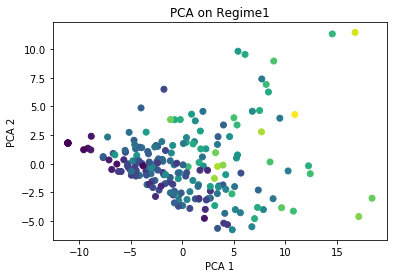

In [16]:
_,_=PCA_plot(df_R1.loc[:,df_R1.columns!='genotype'],2,1)

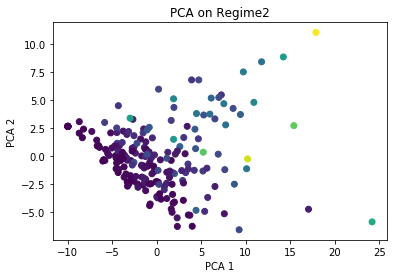

In [17]:
_,_=PCA_plot(df_R2.loc[:,df_R2.columns!='genotype'],2,2)

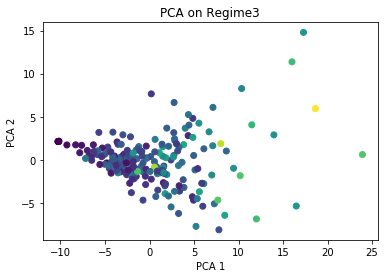

In [18]:
_,_=PCA_plot(df_R3.loc[:,df_R3.columns!='genotype'],2,3)

## 1.5 Genotype Clustering

In [64]:
def get_cluster_labels(df2pca,df,n_clusters):
    """
    Get the cluster labels for the dataframe given
    """
    temp=df.copy()
    df_scaled=StandardScaler().fit_transform(df2pca)
    pca=PCA(n_components=2)
    pca.fit(df_scaled)
    df_pca=pca.transform(df_scaled)
    kmeans=KMeans(n_clusters=n_clusters,random_state=0).fit(df_pca)
    centroids = kmeans.cluster_centers_
    labels=kmeans.labels_
    temp["label"]=labels
    label_count=temp[['genotype','label']].groupby(['label']).agg(['count'])

    #create label dictionary with genotype as values and label as keys
    label_dict={}
    for i in range(4):
        label_dict[i]=[]
    for i in range(len(df)):
        label_dict[temp.iloc[i]['label']].append(temp.iloc[i]['genotype'])

    return label_count.to_numpy(),label_dict,df_pca,labels

In [65]:
count_R1,label_dict_R1,pca_df_R1,labels_R1=get_cluster_labels(df_R1.loc[:,df_R1.columns!='genotype'],df_R1,4)
count_R2,label_dict_R2,pca_df_R2,labels_R2=get_cluster_labels(df_R2.loc[:,df_R2.columns!='genotype'],df_R2,4)
count_R3,label_dict_R3,pca_df_R3,labels_R3=get_cluster_labels(df_R3.loc[:,df_R3.columns!='genotype'],df_R3,4)

**Nota Bene:** the label dicts contains the cluster associated to each genotype

In [21]:
for i in label_dict_R1:
    print(
        "{}\t{}".format("Cluster number {} for Regime 1 contains the following genotypes :".format(i+1),label_dict_R1[i]))

Cluster number 1 for Regime 1 contains the following genotypes :	[';;ort^1, HisCl1^134', 'Canton-S', 'RAL-100', 'RAL-105', 'RAL-158', 'RAL-177', 'RAL-181', 'RAL-195', 'RAL-21', 'RAL-217', 'RAL-227', 'RAL-228', 'RAL-239', 'RAL-256', 'RAL-280', 'RAL-303', 'RAL-31', 'RAL-315', 'RAL-319', 'RAL-324', 'RAL-340', 'RAL-355', 'RAL-356', 'RAL-359', 'RAL-362', 'RAL-365', 'RAL-373', 'RAL-374', 'RAL-379', 'RAL-380', 'RAL-382', 'RAL-390', 'RAL-391', 'RAL-399', 'RAL-40', 'RAL-406', 'RAL-42', 'RAL-440', 'RAL-441', 'RAL-486', 'RAL-492', 'RAL-517', 'RAL-530', 'RAL-531', 'RAL-551', 'RAL-563', 'RAL-584', 'RAL-589', 'RAL-59', 'RAL-634', 'RAL-707', 'RAL-712', 'RAL-716', 'RAL-727', 'RAL-730', 'RAL-757', 'RAL-761', 'RAL-765', 'RAL-774', 'RAL-796', 'RAL-802', 'RAL-804', 'RAL-808', 'RAL-812', 'RAL-818', 'RAL-819', 'RAL-821', 'RAL-83', 'RAL-832', 'RAL-837', 'RAL-85', 'RAL-852', 'RAL-855', 'RAL-859', 'RAL-861', 'RAL-88', 'RAL-884', 'RAL-890', 'RAL-892', 'RAL-900', 'RAL-907', 'RAL-908', 'RAL-913', 'norpA^24;;']
Cl

In [22]:
for i in label_dict_R2:
    print(
        "{}\t{}".format("Cluster number {} for Regime 2 contains the following genotypes :".format(i+1),label_dict_R2[i]))

Cluster number 1 for Regime 2 contains the following genotypes :	['RAL-101', 'RAL-109', 'RAL-129', 'RAL-138', 'RAL-237', 'RAL-26', 'RAL-310', 'RAL-320', 'RAL-335', 'RAL-336', 'RAL-361', 'RAL-375', 'RAL-385', 'RAL-395', 'RAL-491', 'RAL-502', 'RAL-505', 'RAL-509', 'RAL-513', 'RAL-627', 'RAL-630', 'RAL-639', 'RAL-705', 'RAL-714', 'RAL-732', 'RAL-738', 'RAL-786', 'RAL-822', 'RAL-849', 'RAL-911']
Cluster number 2 for Regime 2 contains the following genotypes :	['RAL-142', 'RAL-149', 'RAL-161', 'RAL-176', 'RAL-195', 'RAL-229', 'RAL-28', 'RAL-301', 'RAL-304', 'RAL-306', 'RAL-309', 'RAL-313', 'RAL-317', 'RAL-32', 'RAL-321', 'RAL-338', 'RAL-340', 'RAL-352', 'RAL-357', 'RAL-359', 'RAL-360', 'RAL-371', 'RAL-374', 'RAL-377', 'RAL-381', 'RAL-383', 'RAL-392', 'RAL-41', 'RAL-439', 'RAL-461', 'RAL-486', 'RAL-528', 'RAL-535', 'RAL-555', 'RAL-559', 'RAL-57', 'RAL-59', 'RAL-634', 'RAL-712', 'RAL-721', 'RAL-73', 'RAL-730', 'RAL-737', 'RAL-748', 'RAL-75', 'RAL-776', 'RAL-783', 'RAL-799', 'RAL-804', 'RAL-80

In [23]:
for i in label_dict_R3:
    print(
        "{}\t{}".format("Cluster number {} for Regime 3 contains the following genotypes :".format(i+1),label_dict_R3[i]))

Cluster number 1 for Regime 3 contains the following genotypes :	['RAL-101', 'RAL-109', 'RAL-136', 'RAL-138', 'RAL-161', 'RAL-181', 'RAL-237', 'RAL-26', 'RAL-287', 'RAL-310', 'RAL-319', 'RAL-320', 'RAL-335', 'RAL-336', 'RAL-361', 'RAL-375', 'RAL-385', 'RAL-491', 'RAL-505', 'RAL-509', 'RAL-513', 'RAL-627', 'RAL-639', 'RAL-705', 'RAL-714', 'RAL-732', 'RAL-765', 'RAL-786', 'RAL-801', 'RAL-822', 'RAL-849', 'RAL-911']
Cluster number 2 for Regime 3 contains the following genotypes :	['RAL-142', 'RAL-158', 'RAL-176', 'RAL-195', 'RAL-229', 'RAL-28', 'RAL-309', 'RAL-313', 'RAL-315', 'RAL-317', 'RAL-32', 'RAL-321', 'RAL-338', 'RAL-340', 'RAL-350', 'RAL-352', 'RAL-357', 'RAL-358', 'RAL-360', 'RAL-365', 'RAL-371', 'RAL-377', 'RAL-38', 'RAL-381', 'RAL-383', 'RAL-391', 'RAL-392', 'RAL-397', 'RAL-399', 'RAL-41', 'RAL-427', 'RAL-437', 'RAL-439', 'RAL-440', 'RAL-443', 'RAL-45', 'RAL-461', 'RAL-530', 'RAL-535', 'RAL-551', 'RAL-555', 'RAL-559', 'RAL-563', 'RAL-57', 'RAL-59', 'RAL-595', 'RAL-634', 'RAL-71

Text(0, 0.5, 'Genotype Count')

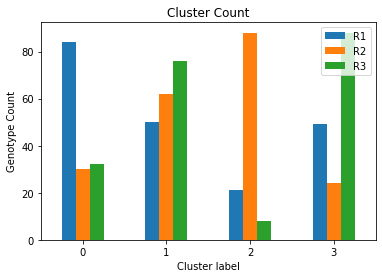

In [24]:
pd.DataFrame(np.concatenate((count_R1,count_R2,count_R3),axis=1),columns=['R1','R2','R3']).plot(kind='bar',rot=0)
plt.title('Cluster Count')
plt.xlabel('Cluster label')
plt.ylabel('Genotype Count')

**Observation** We see here the count of genotype for each cluster and each regime. The cluster 0 is the more common with an overall of 80 on each regime. Cluster 1 is more present for the R2 as the Cluster 2 is for R3.

Text(0, 0.5, 'PCA 2')

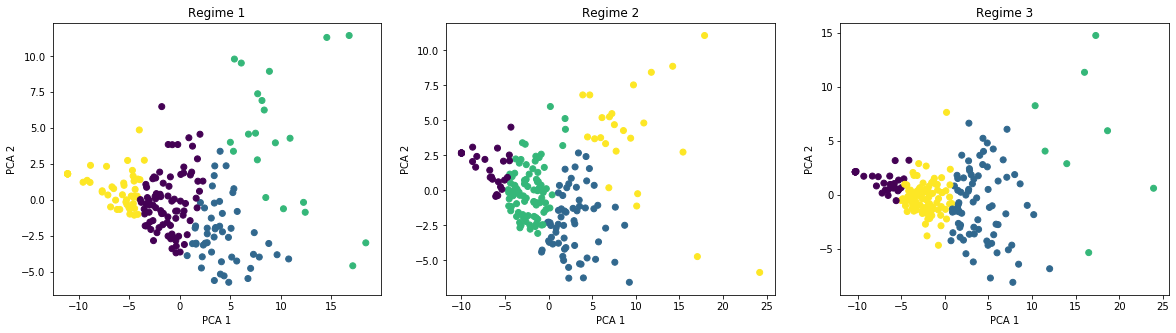

In [25]:
fig,ax=plt.subplots(1,3,figsize=(20,5))
ax[0].scatter(pca_df_R1[:,0],pca_df_R1[:,1],c=labels_R1)
ax[0].set_title('Regime 1')
ax[0].set_xlabel('PCA 1')
ax[0].set_ylabel('PCA 2')
ax[1].scatter(pca_df_R2[:,0],pca_df_R2[:,1],c=labels_R2)
ax[1].set_title('Regime 2')
ax[1].set_xlabel('PCA 1')
ax[1].set_ylabel('PCA 2')
ax[2].scatter(pca_df_R3[:,0],pca_df_R3[:,1],c=labels_R3)
ax[2].set_title('Regime 3')
ax[2].set_xlabel('PCA 1')
ax[2].set_ylabel('PCA 2')

**Observation** Here we have the plot of the genotypes along PCA1 and PCA2 and the clusters asssociated we have a cluster for the "outliers" then we have a big crowd divided in 3 clusters.

## 1.6 Bin Clustering based on time of the day

In [26]:
def color_grade_point():
    """
    set the color of the grade point for specific time of the day
    """
    color=[]
    for i in range(48):
        if i<14:#from midnight to 7am (night)
            color.append('#1B0FFF')#BLUE
        elif i<24:#from 7am to 12pm (morning)
            color.append('#FF0FE4')#PINK
        elif i<34:#from 12pm to 5pm (afternoon)
            color.append('#1AFF25')#GREEN
        elif i<48:#from 5pm to midnight (evening)
            color.append('#FF900F')#ORANGE
    
    return color

In [27]:
_,comp_pca_R1=PCA_plot(df_R1.loc[:,df_R1.columns!='genotype'],5,1)
_,comp_pca_R2=PCA_plot(df_R2.loc[:,df_R2.columns!='genotype'],5,2)
_,comp_pca_R3=PCA_plot(df_R3.loc[:,df_R3.columns!='genotype'],5,3)
df_comp_pca_R1=pd.DataFrame(comp_pca_R1,columns=['bin '+str(i+1) for i in range(48)]).T
df_comp_pca_R1.columns=['pca_'+str(i+1) for i in range(5)]
df_comp_pca_R2=pd.DataFrame(comp_pca_R2,columns=['bin '+str(i+1) for i in range(48)]).T
df_comp_pca_R2.columns=['pca_'+str(i+1) for i in range(5)]
df_comp_pca_R3=pd.DataFrame(comp_pca_R3,columns=['bin '+str(i+1) for i in range(48)]).T
df_comp_pca_R3.columns=['pca_'+str(i+1) for i in range(5)]

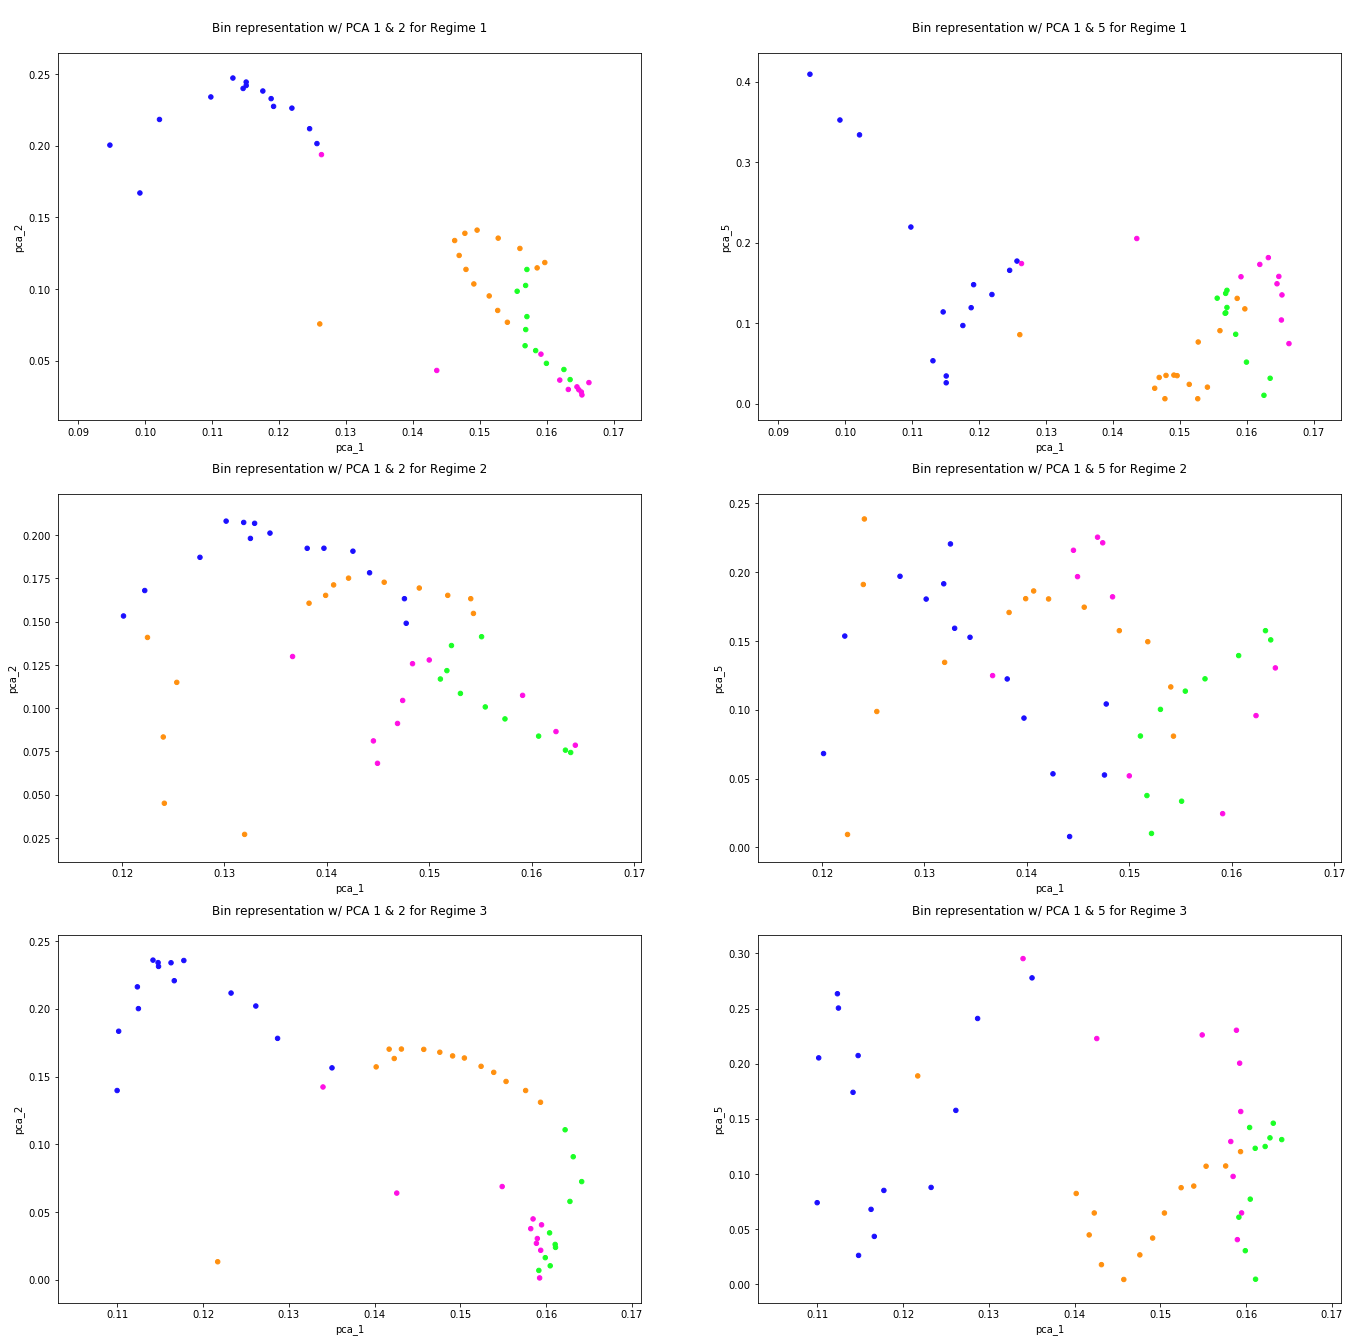

In [28]:
fig,ax=plt.subplots(3,2,figsize=(23,23))
df_comp_pca_R1.plot(kind='scatter',x='pca_1',y='pca_2',color=color_grade_point(),ax=ax[0,0],title='\nBin representation w/ PCA 1 & 2 for Regime 1\n')
df_comp_pca_R1.plot(kind='scatter',x='pca_1',y='pca_5',color=color_grade_point(),ax=ax[0,1],title='\nBin representation w/ PCA 1 & 5 for Regime 1\n')
df_comp_pca_R2.plot(kind='scatter',x='pca_1',y='pca_2',color=color_grade_point(),ax=ax[1,0],title='\nBin representation w/ PCA 1 & 2 for Regime 2\n')
df_comp_pca_R2.plot(kind='scatter',x='pca_1',y='pca_5',color=color_grade_point(),ax=ax[1,1],title='\nBin representation w/ PCA 1 & 5 for Regime 2\n')
df_comp_pca_R3.plot(kind='scatter',x='pca_1',y='pca_2',color=color_grade_point(),ax=ax[2,0],title='\nBin representation w/ PCA 1 & 2 for Regime 3\n')
df_comp_pca_R3.plot(kind='scatter',x='pca_1',y='pca_5',color=color_grade_point(),ax=ax[2,1],title='\nBin representation w/ PCA 1 & 5 for Regime 3\n')

**Observation** : In this graph we plotted the bin values by associating to them a color depending on their time in the day (morning afternoon evening etc...). We tried plotting with various combination of the axis the best one was PCA 1 for x and PCA 2 for y. The cluster are really disctinct for the regime 1 and 3. Not for the regime 2 because the 12-12 hours regime implies a confusion "between the afternoon and evening for instance.

For regime 1 and 3, the pink and green color are really close to each other because it correspond to the morning and afternoon and with the first plot of this notebook we observe a similar profile of activity during those periods.

# 2. Tensorial study

The purpose of this step is to consider the inherently tensor nature of the proposed dataset. 
We no longer average over days and we test tensor methods to process the dataset 

## 2.1 3D Tensor Study

First, we will work on a 3D tensor. For this, we create a 3D matrix average_drosophila_profile x activity per day x day.

In order to do that, we create a dataframe per genotype and per regime for the 240 bins and we reshape it. 

In [29]:
df=pd.read_csv('Table_data_total.csv',sep=';',header=0)

In [30]:
df_genotypes = df.drop(['date','refMC'],axis=1)
df_genotypes = df_genotypes.groupby(['genotype','R']).mean()

In [31]:
df_genotypes.head(5)

Bin 1     Bin 2     Bin 3     Bin 4     Bin 5  \
genotype            R                                                      
;;cry^02            1   6.468750  1.587500  0.806250  0.884375  0.890625   
                    2   4.278125  3.062500  2.450000  1.800000  1.518750   
                    3   3.303125  1.503125  1.168750  0.950000  0.696875   
;;ort^1, HisCl1^134 1  15.412698  6.206349  2.888889  3.663492  3.501587   
                    2  13.584127  7.939683  4.882540  3.488889  2.584127   

                          Bin 6     Bin 7     Bin 8     Bin 9    Bin 10  ...  \
genotype            R                                                    ...   
;;cry^02            1  1.106250  1.646875  1.003125  2.300000  2.418750  ...   
                    2  1.565625  2.412500  1.665625  2.625000  2.434375  ...   
                    3  1.106250  0.653125  0.915625  0.943750  1.400000  ...   
;;ort^1, HisCl1^134 1  3.676190  4.939683  3.593651  4.965079  5.533333  ...   
                    2  4.212698  3.930159  3.930159  4.590476  5.838095  ...   

                         Bin 231    Bin 232    Bin 233    Bin 234    Bin 235  \
genotype            R                                                          
;;cry^02            1  16.687500  17.400000  19.959375  20.843750  23.834375   
                    2  14.987500  17.068750  18.415625  20.853125  22.234375   
                    3  17.456250  19.359375  19.815625  21.631250  22.075000   
;;ort^1, HisCl1^134 1  22.133333  25.869841  30.012698  36.473016  36.946032   
                    2  17.911111  19.638095  23.038095  29.701587  30.098413   

                         Bin 236    Bin 237    Bin 238    Bin 239    Bin 240  
genotype            R                                                         
;;cry^02            1  25.278125  29.368750  29.859375  31.728125  56.953125  
                    2  41.356250  13.668750   7.881250   4.490625   2.931250  
                    3  23.790625  24.756250  24.693750  26.315625  22.050000  
;;ort^1, HisCl1^134 1  38.514286  36.876190  32.142857  24.269841  32.666667  
                    2  35.346032  32.580952  21.117460  14.288889   9.244444  

[5 rows x 240 columns]

In [32]:
R_1_3D=[]
R_2_3D=[]
R_3_3D=[]
for info,data in df_genotypes.iterrows():
    data=list(data)
    data.append(info[0])
    if info[1]==1:
        R_1_3D.append(data)
    elif info[1]==2:
        R_2_3D.append(data)
    elif info[1]==3:
        R_3_3D.append(data)

df_R1_3D=pd.DataFrame(R_1_3D,columns=list(df_genotypes.columns)+['genotype'])
df_R2_3D=pd.DataFrame(R_2_3D,columns=df_R1_3D.columns)
df_R3_3D=pd.DataFrame(R_3_3D,columns=df_R1_3D.columns)

In [33]:
df_R1_3D.head(5)

,Bin 1,Bin 2,Bin 3,Bin 4,Bin 5,Bin 6,Bin 7,Bin 8,Bin 9,Bin 10,...,Bin 232,Bin 233,Bin 234,Bin 235,Bin 236,Bin 237,Bin 238,Bin 239,Bin 240,genotype
0,6.468750,1.587500,0.806250,0.884375,0.890625,1.10625,1.646875,1.003125,2.300000,2.418750,...,17.400000,19.959375,20.843750,23.834375,25.278125,29.368750,29.859375,31.728125,56.953125,;;cry^02
1,15.412698,6.206349,2.888889,3.663492,3.501587,3.67619,4.939683,3.593651,4.965079,5.533333,...,25.869841,30.012698,36.473016,36.946032,38.514286,36.876190,32.142857,24.269841,32.666667,";;ort^1, HisCl1^134"
2,0.787500,1.100000,1.225000,1.659375,1.153125,1.48750,1.678125,2.553125,1.740625,1.806250,...,28.056250,30.593750,33.018750,33.606250,35.181250,35.271875,35.850000,33.903125,35.153125,Canton-S
3,0.125000,0.906250,2.187500,2.312500,1.312500,1.12500,1.343750,1.187500,1.406250,0.437500,...,42.093750,47.468750,54.656250,50.968750,54.312500,48.031250,42.062500,32.437500,16.875000,RAL-100
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,RAL-101


In [34]:
np.shape(df_R1_3D)

(204, 241)

In [35]:
R1_3D_array = pd.DataFrame(df_R1_3D.loc[:,df_R1_3D.columns!='genotype']).to_numpy()
R2_3D_array = pd.DataFrame(df_R2_3D.loc[:,df_R2_3D.columns!='genotype']).to_numpy()
R3_3D_array = pd.DataFrame(df_R3_3D.loc[:,df_R3_3D.columns!='genotype']).to_numpy()

In [36]:
R1_3D = R1_3D_array.reshape(204,5,48)
R2_3D = R2_3D_array.reshape(204,5,48)
R3_3D = R3_3D_array.reshape(204,5,48)

In [37]:
R1_3D.shape

(204, 5, 48)

In [60]:
R1_3D[0][0]

array([ 6.46875 ,  1.5875  ,  0.80625 ,  0.884375,  0.890625,  1.10625 ,
        1.646875,  1.003125,  2.3     ,  2.41875 ,  2.6875  ,  3.3     ,
        3.290625,  4.259375,  4.615625, 36.89375 , 23.925   , 14.1875  ,
        9.8625  ,  8.1875  ,  7.      ,  6.259375,  5.534375,  5.3125  ,
        5.88125 ,  6.384375,  5.540625,  5.1125  ,  6.059375,  5.371875,
        5.590625,  5.896875,  7.30625 ,  7.671875,  8.484375,  8.5875  ,
       10.91875 , 13.521875, 15.646875, 16.759375, 21.671875, 24.09375 ,
       26.95625 , 30.5375  , 31.19375 , 33.76875 , 34.440625, 61.228125])

### 2.1.1 PARAFAC / CANDECOMP decomposition

We use the PARAFAC model that allows canonical decomposition as a PCA generalization. For that, we use the tensorly library

In [39]:
weights_R1, factors_R1 = parafac(R1_3D, rank=3,init='random',random_state=np.random.randint(0,1))
weights_R2, factors_R2 = parafac(R2_3D, rank=3,init='random',random_state=np.random.randint(0,1))
weights_R3, factors_R3 = parafac(R1_3D, rank=3,init='random',random_state=np.random.randint(0,1))

We display the dimensions of the three factors

In [40]:
[f.shape for f in factors_R1]

[(204, 3), (5, 3), (48, 3)]

### 2.1.2 3D Tensors Clustering Study on Genotype Factor Matrix (Kmeans)

We perform K-Means on the obtained Genotype factor Matrix. For that, we use the Kmeans functionality from the scikit learn library as before.

In [41]:
def get_cluster_labels_3D(Z,df,n_clusters):
    """
    Get the cluster labels for the dataframe given
    """
    temp=df.copy()
    kmeans = KMeans(n_clusters = 4)
    kmeans.fit(Z)
    y_kmeans = kmeans.predict(Z)
    labels=kmeans.labels_
    temp["label"]=labels
    label_count=temp[['genotype','label']].groupby(['label']).agg(['count'])

    #create label dictionary with genotype as values and label as keys
    label_dict={}
    for i in range(4):
        label_dict[i]=[]
    for i in range(len(df)):
        label_dict[temp.iloc[i]['label']].append(temp.iloc[i]['genotype'])

    return label_count.to_numpy(),label_dict,labels

In [42]:
count_R1_3D,label_dict_R1_3D,labels_R1_3D=get_cluster_labels_3D(pd.DataFrame(factors_R1[0]),df_R1_3D,4)
count_R2_3D,label_dict_R2_3D,labels_R2_3D=get_cluster_labels_3D(pd.DataFrame(factors_R2[0]),df_R2_3D,4)
count_R3_3D,label_dict_R3_3D,labels_R3_3D=get_cluster_labels_3D(pd.DataFrame(factors_R3[0]),df_R3_3D,4)

Text(0, 0.5, 'Genotype Count')

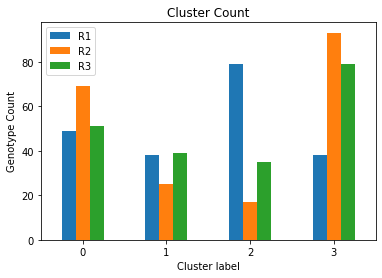

In [43]:
pd.DataFrame(np.concatenate((count_R1_3D,count_R2_3D,count_R3_3D),axis=1),columns=['R1','R2','R3']).plot(kind='bar',rot=0)
plt.title('Cluster Count')
plt.xlabel('Cluster label')
plt.ylabel('Genotype Count')

Here we compute the number of drosophila per clusters for each regime.

Text(0, 0.5, 'PARAFAC 2')

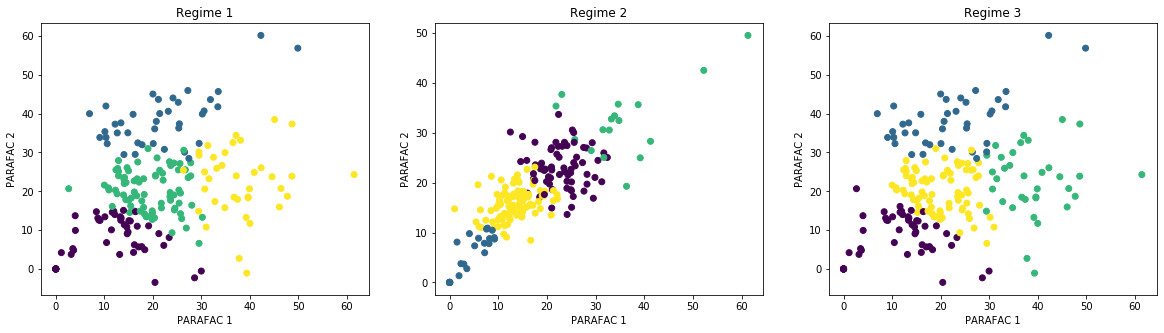

In [44]:
fig,ax=plt.subplots(1,3,figsize=(20,5))
ax[0].scatter(factors_R1[0][:,0],factors_R1[0][:,2],c=labels_R1_3D)
ax[0].set_title('Regime 1')
ax[0].set_xlabel('PARAFAC 1')
ax[0].set_ylabel('PARAFAC 2')
ax[1].scatter(factors_R2[0][:,0],factors_R2[0][:,2],c=labels_R2_3D)
ax[1].set_title('Regime 2')
ax[1].set_xlabel('PARAFAC 1')
ax[1].set_ylabel('PARAFAC 2')
ax[2].scatter(factors_R3[0][:,0],factors_R3[0][:,2],c=labels_R3_3D)
ax[2].set_title('Regime 3')
ax[2].set_xlabel('PARAFAC 1')
ax[2].set_ylabel('PARAFAC 2')

Below is a 3D representation taking into account the 3 PARAFAC computed factors

Text(0.5, 0.92, 'Regime 2')

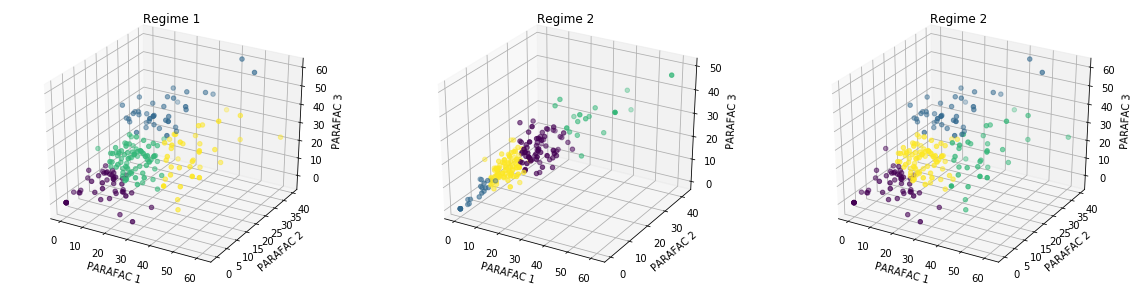

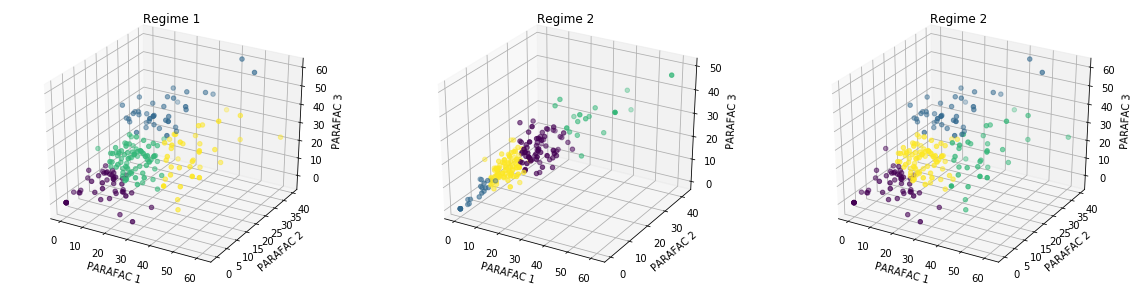

In [45]:

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(factors_R1[0][:,0],factors_R1[0][:,1],factors_R1[0][:,2],c=labels_R1_3D)
ax.set_xlabel('PARAFAC 1', rotation=150)
ax.set_ylabel('PARAFAC 2')
ax.set_zlabel('PARAFAC 3', rotation=60)
ax.set_title('Regime 1')
ax = fig.add_subplot(132, projection='3d')
ax.scatter(factors_R2[0][:,0],factors_R2[0][:,1],factors_R2[0][:,2],c=labels_R2_3D)
ax.set_xlabel('PARAFAC 1', rotation=150)
ax.set_ylabel('PARAFAC 2')
ax.set_zlabel('PARAFAC 3', rotation=60)
ax.set_title('Regime 2')
ax = fig.add_subplot(133, projection='3d')
ax.scatter(factors_R3[0][:,0],factors_R3[0][:,1],factors_R3[0][:,2],c=labels_R3_3D)
ax.set_xlabel('PARAFAC 1', rotation=150)
ax.set_ylabel('PARAFAC 2')
ax.set_zlabel('PARAFAC 3', rotation=60)
ax.set_title('Regime 2')

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(factors_R1[0][:,0],factors_R1[0][:,1],factors_R1[0][:,2],c=labels_R1_3D)
ax.set_xlabel('PARAFAC 1', rotation=150)
ax.set_ylabel('PARAFAC 2')
ax.set_zlabel('PARAFAC 3', rotation=60)
ax.set_title('Regime 1')
ax = fig.add_subplot(132, projection='3d')
ax.scatter(factors_R2[0][:,0],factors_R2[0][:,1],factors_R2[0][:,2],c=labels_R2_3D)
ax.set_xlabel('PARAFAC 1', rotation=150)
ax.set_ylabel('PARAFAC 2')
ax.set_zlabel('PARAFAC 3', rotation=60)
ax.set_title('Regime 2')
ax = fig.add_subplot(133, projection='3d')
ax.scatter(factors_R3[0][:,0],factors_R3[0][:,1],factors_R3[0][:,2],c=labels_R3_3D)
ax.set_xlabel('PARAFAC 1', rotation=150)
ax.set_ylabel('PARAFAC 2')
ax.set_zlabel('PARAFAC 3', rotation=60)
ax.set_title('Regime 2')


**Observation** : Clustering with PARAFAC study on the 3D tensor for each regime allows to distinguish 4 different clusters for each regime. We can seperate the drosophila population on 4 different behaviors regarding their genotypes. 

Below, we display the labels contained in each clusters, i.e the various genotypes belonging to the different clusters (4) we obtained based on the bin factor matrix from the PARAFAC study. We do that for each of the 3 regimes. 

In [46]:
for i in label_dict_R1_3D:
    print("{}\t{}".format("Cluster number {} for Regime 1 contains the following genotypes :".format(i+1),label_dict_R1_3D[i]))

Cluster number 1 for Regime 1 contains the following genotypes :	[';;cry^02', 'RAL-101', 'RAL-109', 'RAL-129', 'RAL-136', 'RAL-138', 'RAL-189', 'RAL-235', 'RAL-237', 'RAL-26', 'RAL-287', 'RAL-307', 'RAL-310', 'RAL-318', 'RAL-320', 'RAL-332', 'RAL-335', 'RAL-336', 'RAL-348', 'RAL-354', 'RAL-361', 'RAL-375', 'RAL-385', 'RAL-395', 'RAL-405', 'RAL-409', 'RAL-42', 'RAL-45', 'RAL-48', 'RAL-491', 'RAL-502', 'RAL-505', 'RAL-509', 'RAL-513', 'RAL-627', 'RAL-630', 'RAL-639', 'RAL-646', 'RAL-69', 'RAL-705', 'RAL-714', 'RAL-732', 'RAL-738', 'RAL-786', 'RAL-801', 'RAL-822', 'RAL-849', 'RAL-879', 'RAL-911']
Cluster number 2 for Regime 1 contains the following genotypes :	['RAL-149', 'RAL-161', 'RAL-176', 'RAL-229', 'RAL-28', 'RAL-309', 'RAL-313', 'RAL-317', 'RAL-360', 'RAL-367', 'RAL-377', 'RAL-381', 'RAL-386', 'RAL-392', 'RAL-397', 'RAL-41', 'RAL-443', 'RAL-528', 'RAL-555', 'RAL-566', 'RAL-596', 'RAL-721', 'RAL-73', 'RAL-730', 'RAL-737', 'RAL-748', 'RAL-75', 'RAL-776', 'RAL-787', 'RAL-790', 'RAL-79

In [47]:
for i in label_dict_R2_3D:
    print("{}\t{}".format("Cluster number {} for Regime 2 contains the following genotypes :".format(i+1),label_dict_R2_3D[i]))

Cluster number 1 for Regime 2 contains the following genotypes :	['RAL-142', 'RAL-149', 'RAL-176', 'RAL-195', 'RAL-229', 'RAL-28', 'RAL-301', 'RAL-304', 'RAL-306', 'RAL-309', 'RAL-313', 'RAL-315', 'RAL-317', 'RAL-32', 'RAL-321', 'RAL-338', 'RAL-340', 'RAL-350', 'RAL-352', 'RAL-358', 'RAL-360', 'RAL-365', 'RAL-370', 'RAL-371', 'RAL-374', 'RAL-38', 'RAL-381', 'RAL-383', 'RAL-391', 'RAL-392', 'RAL-397', 'RAL-41', 'RAL-427', 'RAL-443', 'RAL-461', 'RAL-486', 'RAL-528', 'RAL-531', 'RAL-535', 'RAL-555', 'RAL-559', 'RAL-57', 'RAL-59', 'RAL-634', 'RAL-712', 'RAL-721', 'RAL-727', 'RAL-73', 'RAL-730', 'RAL-748', 'RAL-776', 'RAL-783', 'RAL-787', 'RAL-804', 'RAL-805', 'RAL-819', 'RAL-83', 'RAL-832', 'RAL-843', 'RAL-853', 'RAL-857', 'RAL-859', 'RAL-861', 'RAL-887', 'RAL-890', 'RAL-897', 'RAL-900', 'RAL-91', 'RAL-93']
Cluster number 2 for Regime 2 contains the following genotypes :	['RAL-101', 'RAL-109', 'RAL-129', 'RAL-138', 'RAL-26', 'RAL-310', 'RAL-320', 'RAL-335', 'RAL-336', 'RAL-361', 'RAL-375',

In [48]:
for i in label_dict_R3_3D:
    print(
        "{}\t{}".format("Cluster number {} for Regime 3 contains the following genotypes :".format(i+1),label_dict_R3_3D[i]))

Cluster number 1 for Regime 3 contains the following genotypes :	[';;cry^02', 'RAL-101', 'RAL-109', 'RAL-129', 'RAL-136', 'RAL-138', 'RAL-189', 'RAL-235', 'RAL-237', 'RAL-26', 'RAL-287', 'RAL-307', 'RAL-310', 'RAL-318', 'RAL-320', 'RAL-332', 'RAL-335', 'RAL-336', 'RAL-348', 'RAL-354', 'RAL-361', 'RAL-375', 'RAL-385', 'RAL-395', 'RAL-405', 'RAL-409', 'RAL-42', 'RAL-45', 'RAL-48', 'RAL-491', 'RAL-502', 'RAL-505', 'RAL-509', 'RAL-513', 'RAL-627', 'RAL-630', 'RAL-639', 'RAL-646', 'RAL-69', 'RAL-705', 'RAL-714', 'RAL-732', 'RAL-738', 'RAL-786', 'RAL-801', 'RAL-822', 'RAL-849', 'RAL-879', 'RAL-907', 'RAL-911', 'norpA^24;;']
Cluster number 2 for Regime 3 contains the following genotypes :	['RAL-149', 'RAL-161', 'RAL-176', 'RAL-229', 'RAL-28', 'RAL-309', 'RAL-313', 'RAL-317', 'RAL-360', 'RAL-367', 'RAL-377', 'RAL-381', 'RAL-386', 'RAL-392', 'RAL-397', 'RAL-41', 'RAL-443', 'RAL-528', 'RAL-555', 'RAL-566', 'RAL-596', 'RAL-721', 'RAL-73', 'RAL-730', 'RAL-737', 'RAL-748', 'RAL-75', 'RAL-776', 'RAL

## 2.2 4D Tensor Study

Now, we will work on a 4D tensor, taking into account the regimes in our clustering method. Again, we will use the same method, using PARAFAC decomposition and KMeans clustering on the Genotypes Factor Matrix. 
That will allow us to display 4 clusters to classify our drosophilas genotypes according to their circadian rhythm.


First, let's create our 4D tensor (average_drosophila_profile x activity per day x day x regime)

In [49]:
df_genotypes.head(5)

Bin 1     Bin 2     Bin 3     Bin 4     Bin 5  \
genotype            R                                                      
;;cry^02            1   6.468750  1.587500  0.806250  0.884375  0.890625   
                    2   4.278125  3.062500  2.450000  1.800000  1.518750   
                    3   3.303125  1.503125  1.168750  0.950000  0.696875   
;;ort^1, HisCl1^134 1  15.412698  6.206349  2.888889  3.663492  3.501587   
                    2  13.584127  7.939683  4.882540  3.488889  2.584127   

                          Bin 6     Bin 7     Bin 8     Bin 9    Bin 10  ...  \
genotype            R                                                    ...   
;;cry^02            1  1.106250  1.646875  1.003125  2.300000  2.418750  ...   
                    2  1.565625  2.412500  1.665625  2.625000  2.434375  ...   
                    3  1.106250  0.653125  0.915625  0.943750  1.400000  ...   
;;ort^1, HisCl1^134 1  3.676190  4.939683  3.593651  4.965079  5.533333  ...   
                    2  4.212698  3.930159  3.930159  4.590476  5.838095  ...   

                         Bin 231    Bin 232    Bin 233    Bin 234    Bin 235  \
genotype            R                                                          
;;cry^02            1  16.687500  17.400000  19.959375  20.843750  23.834375   
                    2  14.987500  17.068750  18.415625  20.853125  22.234375   
                    3  17.456250  19.359375  19.815625  21.631250  22.075000   
;;ort^1, HisCl1^134 1  22.133333  25.869841  30.012698  36.473016  36.946032   
                    2  17.911111  19.638095  23.038095  29.701587  30.098413   

                         Bin 236    Bin 237    Bin 238    Bin 239    Bin 240  
genotype            R                                                         
;;cry^02            1  25.278125  29.368750  29.859375  31.728125  56.953125  
                    2  41.356250  13.668750   7.881250   4.490625   2.931250  
                    3  23.790625  24.756250  24.693750  26.315625  22.050000  
;;ort^1, HisCl1^134 1  38.514286  36.876190  32.142857  24.269841  32.666667  
                    2  35.346032  32.580952  21.117460  14.288889   9.244444  

[5 rows x 240 columns]

In [50]:
np.shape(df_genotypes)

(612, 240)

In [51]:
array = pd.DataFrame(df_genotypes).to_numpy()
New_4D_array = array.reshape(204,3,5,48)

In [52]:
New_4D_array.shape

(204, 3, 5, 48)

In [61]:
New_4D_array[0][0][0]

array([ 6.46875 ,  1.5875  ,  0.80625 ,  0.884375,  0.890625,  1.10625 ,
        1.646875,  1.003125,  2.3     ,  2.41875 ,  2.6875  ,  3.3     ,
        3.290625,  4.259375,  4.615625, 36.89375 , 23.925   , 14.1875  ,
        9.8625  ,  8.1875  ,  7.      ,  6.259375,  5.534375,  5.3125  ,
        5.88125 ,  6.384375,  5.540625,  5.1125  ,  6.059375,  5.371875,
        5.590625,  5.896875,  7.30625 ,  7.671875,  8.484375,  8.5875  ,
       10.91875 , 13.521875, 15.646875, 16.759375, 21.671875, 24.09375 ,
       26.95625 , 30.5375  , 31.19375 , 33.76875 , 34.440625, 61.228125])

### 2.2.1 PARAFAC / CANDECOMP decomposition 

Likewise, we use the PARAFAC / CANDECOMP decomposition 

In [57]:
weights, factors_4D = parafac(New_4D_array, rank=3,init='random',random_state=np.random.randint(0,1))
print(factors_4D[0][0])

[31.18392851  8.94132634 37.62235165]


In [56]:
[f.shape for f in factors_4D]

[(204, 3), (3, 3), (5, 3), (48, 3)]

### 2.1.2 4D Tensors Clustering Study on Genotype Factor Matrix (Kmeans)

We perform K-Means on the obtained Genotype factor Matrix. For that, we use the Kmeans functionality from the scikit learn library as before.

In [69]:
def get_cluster_labels_4D(df,n_clusters):
    """
    Get the cluster labels for the dataframe given
    """
    temp=df.copy()
    kmeans = KMeans(n_clusters = 4)
    Z = pd.DataFrame(factors_4D[0])
    kmeans.fit(Z)
    centroids = kmeans.cluster_centers_
    y_kmeans = kmeans.predict(Z)
    labels=kmeans.labels_
    temp["label"]=labels
    label_count=temp[['genotype','label']].groupby(['label']).agg(['count'])

    #create label dictionary with genotype as values and label as keys
    label_dict={}
    for i in range(4):
        label_dict[i]=[]
    for i in range(len(df)):
        label_dict[temp.iloc[i]['label']].append(temp.iloc[i]['genotype'])

    return label_count.to_numpy(),label_dict,labels,centroids

In [70]:
count_4D,label_dict_4D,labels_4D, centroids=get_cluster_labels_4D(df_R1_3D,4)

Text(0, 0.5, 'Genotype Count')

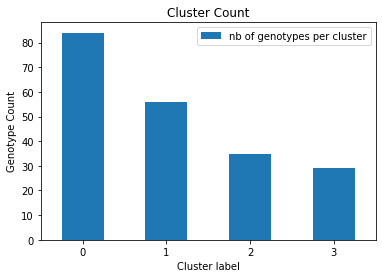

In [71]:
pd.DataFrame(count_4D,columns=['nb of genotypes per cluster']).plot(kind='bar',rot=0)
plt.title('Cluster Count')
plt.xlabel('Cluster label')
plt.ylabel('Genotype Count')

This graph shows the number of drosophila per cluster. The biggest cluster is the first one  with more than 80 genotypes of drosophila. 

Text(0.5, 0.92, '4D tensor clustering')

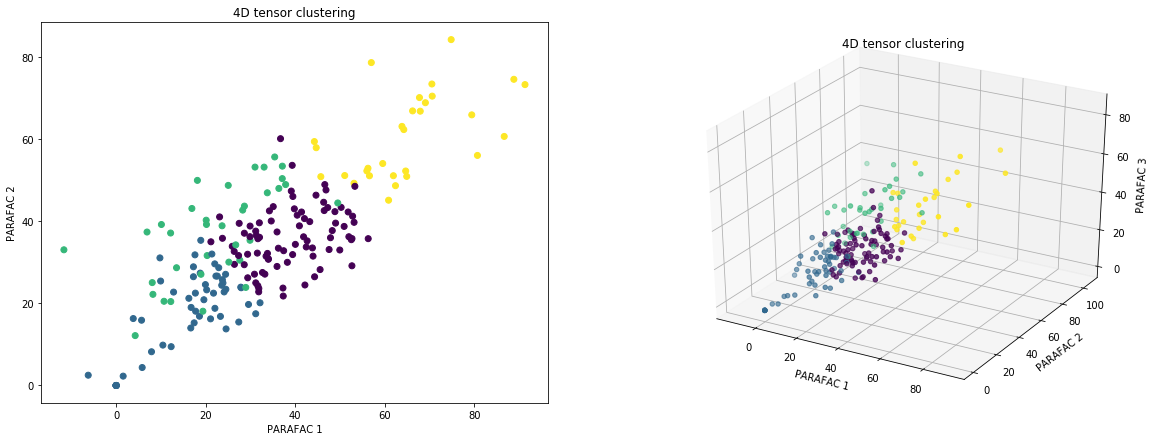

In [74]:
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(121)
ax.scatter(factors_4D[0][:,0],factors_4D[0][:,2],c=labels_4D)
ax.set_title('4D tensor clustering')
ax.set_xlabel('PARAFAC 1')
ax.set_ylabel('PARAFAC 2')
ax = fig.add_subplot(122, projection='3d')
ax.scatter(factors_4D[0][:,0],factors_4D[0][:,1],factors_4D[0][:,2],c=labels_4D)
ax.set_xlabel('PARAFAC 1', rotation=150)
ax.set_ylabel('PARAFAC 2')
ax.set_zlabel('PARAFAC 3', rotation=60)
ax.set_title('4D tensor clustering')


**Observation** : Clustering with PARAFAC study on the 4D tensor for each regime allows to distinguish 4 different clusters taking into account bins differences, day differences, and regime differences. We can seperate the drosophila population on 4 different behaviors regarding their genotypes.

Here, we display the genotypes that belong to each cluster. Genotypes contained in one cluster follow the same conduct according to our study and are supposed to be responsible of a similar behavior in the circadian rhythm. 

In [75]:
for i in label_dict_4D:
    print("{}\t{}".format("Cluster number {} contains the following genotypes :".format(i+1),label_dict_R1_3D[i]))

Cluster number 1 contains the following genotypes :	[';;cry^02', 'RAL-101', 'RAL-109', 'RAL-129', 'RAL-136', 'RAL-138', 'RAL-189', 'RAL-235', 'RAL-237', 'RAL-26', 'RAL-287', 'RAL-307', 'RAL-310', 'RAL-318', 'RAL-320', 'RAL-332', 'RAL-335', 'RAL-336', 'RAL-348', 'RAL-354', 'RAL-361', 'RAL-375', 'RAL-385', 'RAL-395', 'RAL-405', 'RAL-409', 'RAL-42', 'RAL-45', 'RAL-48', 'RAL-491', 'RAL-502', 'RAL-505', 'RAL-509', 'RAL-513', 'RAL-627', 'RAL-630', 'RAL-639', 'RAL-646', 'RAL-69', 'RAL-705', 'RAL-714', 'RAL-732', 'RAL-738', 'RAL-786', 'RAL-801', 'RAL-822', 'RAL-849', 'RAL-879', 'RAL-911']
Cluster number 2 contains the following genotypes :	['RAL-149', 'RAL-161', 'RAL-176', 'RAL-229', 'RAL-28', 'RAL-309', 'RAL-313', 'RAL-317', 'RAL-360', 'RAL-367', 'RAL-377', 'RAL-381', 'RAL-386', 'RAL-392', 'RAL-397', 'RAL-41', 'RAL-443', 'RAL-528', 'RAL-555', 'RAL-566', 'RAL-596', 'RAL-721', 'RAL-73', 'RAL-730', 'RAL-737', 'RAL-748', 'RAL-75', 'RAL-776', 'RAL-787', 'RAL-790', 'RAL-799', 'RAL-805', 'RAL-810', 

# Conclusion

**This work presents different methodologies to help us understand how the genotypes influence the circadian rhythm of drosophila.**

**Thanks to different types of clustering using the collected data on drosophila with mutated genes movements on five days, we are able to distinguish groups that behave the same way.**

**The first part of our work is a Principal Component Analysis (PCA) that computes the principal components and uses them to perform a change of basis on the data. We used only the first principal components that explained the best the data. For that, we average over days, and studied each regime seperately. We found out 4 clusters that regroup the genotypes that behave similarly. We also did a clustering to distinguish the part of the day that are similar.**

**Next, as a second step, we decided to take into account the tensor nature of the proposed dataset. We use the PARAFAC/ CANDECOMP (CP) method.
We no longer average over days and we build a 3D tensor. We find 4 clusters with again the genotypes that behave the same way.**

**Then, as a last study, we build a 4D tensor, taking into account the different regimes, bins per day and day and we build a classification again that distinguish 4 other clusters that behave the same**